In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from SHIPS_preprocess import SHIPS_train_test_split, calc_d24_VMAX, fore_hr_averaging, SHIPS_train_test_shuffle_CLASS
from SHIPS_preprocess import load_processed_SHIPS, calculate_class_weights, get_RI_classes
from SHIPS_ML_model_funcs import apply_class_label, calc_CM_stats, get_scores_class_rept, get_roc_auc, get_feature_importances_RF
from SHIPS_ML_model_funcs import get_confusion_matrix_RF, get_scores_best_params_RF, create_gridsearch_RF, get_train_test_split
from SHIPS_ML_model_funcs import calc_AUPD, calculate_PD_curves
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from SHIPS_plotting import plot_roc_curve, plot_precision_recall_vs_threshold,add_model_results,make_performance_diagram_background
from SHIPS_plotting import plot_CSI_vs_bias, plot_basic_score_basin, plot_PD_curves
import matplotlib.colors


##### Ignore Annoying Warnings

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore",category=ConvergenceWarning)

### Model Parameters

##### SHIPS Dataset Choice
* max_fore: maximum forecast hours [usually 24 or 48]
* mask_TYPE: how are we handling cases close to land? [SIMPLE_MASK or no_MASK]
* interp_str: Did we interpolate over missing data or not? [INTERP: yes, no_INTERP: no]
* pred_set:  Set of predictors we used.  Default is 'BASIC' but if we want to change the predictors we are using we can do that.
* yr_start:  First year of training data [2010 or 2005, generally]
* yr_end:  Last year of training data [2020; data actually ends on 12/31/2019]
* use_basin:  Default is to use all basins, but if we just want to use one basin, we can specify that here [ATLANTIC, EAST_PACIFIC, WEST_PACIFIC, and SOUTH_PACIFIC are the choices]

In [3]:
max_fore = 24 # maximum forecast hours
mask_TYPE = 'SIMPLE_MASK' # how are we handling the land mask?
interp_str = 'INTERP' # did we interpolate?
yr_start = 2005
yr_end = 2019
use_basin = 'ALL'

#### SHIPS analysis choices

In [4]:
hrs_max = 24
drop_features = {'TYPE','VMAX','DELV','VMPI','is_TRAIN'}
to_IND = ['BASIN','CASE','NAME','DATE_full','TIME']
RI_thresh = 30
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True

#### ML Model Hyperparameters.  This will change based on the type of model
* <code>Solver</code>:  For logistic regression models, we have a few choices of solver. We will stick only with solvers that can handle multi-class classification, as we want to be able to compare different formulations of this problem. We have a few options:
 * The default solver, <code>'lbfgs'</code>, (stands for Limited-memory Broyden-Fletcher-Goldfarb-Shanno).  Approximates second derivative with gradient evaluations; only stores last few updates, so saves memory.  Not super fast.
 * <code>sag</code>: stands for "stochastic average gradient".  A version of gradient descent.  Fast for big datasets. 
 * <code>saga</code>: a version of <code>sag</code> that allows for <code>L1</code> regularizaiton. 
* <code> Penalty</code>: Are we regularizing using the L1 norm (absolute-value based) or the L2 norm (least-squares based)? For <code>sag</code> and <code>lbfgs</code>, we will use the <code>L2</code> penalty; for <code>saga</code> we will use <code>L1</code>. 
* <code>k_folds</code>: number of folds used in our cross-validation approach.  We will use a <code>Stratified K-Means cross-validation</code> since we have imbalanced classes. 

##### Class weighting
This part is tricky but important.  Since we are really interested in rapid intensification, which is by definition, rare, we will inherently be creating imbalanced classes for our data.  We can address this in many ways.  Broadly, we can either use <b>class weights</b> (which apply different weights to each data point based on which class it is in), or we can use under/over sampling.  <b>Undersampling</b> means we will sample the minority class at a rate that is commeasurate with the majority class--we lose information, but are less likely to overfit to our minority class.  <b>Oversampling</b> means we will draw additional samples from our minority class to match the size of our majority class.  

We'll try a few different ways of applying class weights, and we'll try undersampling.  Since our minority classes can be quite small, we will avoid oversampling (for now, at least).

In [5]:
score = ['gini']
k_folds = 10
n_repeats = 3

# Weights
use_custom_wts = False
to_predict = 'I_class'
# Model hyperparameters
max_features = [3,4]#,5]#,6]
max_depth = [3,5]#,6]
min_samples_leaf = [2,4]
n_estimators = [250]#,500]

In [6]:
fig_format = 'png'

##### Load our pre-processed SHIPS files

In [7]:
SHIPS_predictors,BASIN = load_processed_SHIPS(yr_start,yr_end,mask_TYPE,max_fore,interp_str,use_basin)

##### Create file output names

##### Calculate class weights, if desired

In [8]:
if use_custom_wts:
    class_wts = calculate_class_weights(SHIPS_predictors,n_classes,RI_thresh,0)
    weights_use = class_wts.xs(use_basin)
    wts_sel = weights_use['WEIGHT'].to_dict()
    wts_str = 'custom_wts'
else:
    wts_sel = 0
    wts_str = 'default_wts'

##### Set up bootstrapping

In [9]:
predicted_y_ALL = pd.DataFrame()
roc_vals_ALL = pd.DataFrame()
p_vs_r_ALL = pd.DataFrame()
fi_pred_ALL = pd.DataFrame()
fi_pred_train_ALL = pd.DataFrame()
cm_ALL = pd.DataFrame()
report_ALL = pd.DataFrame()

In [10]:
N_samples = 1
ncats = 2
scoring = 'f1_weighted'
FULL_yrs = np.arange(yr_start,yr_end,1)
n_valid = 3 # number of years to leave out for validation

for i in np.arange(0,N_samples):
    #i = 0
    print('running sample ',i)
    test_years = np.random.choice(FULL_yrs,n_valid,replace=False)
    X_train, X_test, y_train, y_test, feature_names, diff_train, diff_test = get_train_test_split(test_years,SHIPS_predictors,to_predict,
                                                                    is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)
    #

    LR_model = create_gridsearch_RF(is_standard,score,max_depth,n_estimators,max_features,min_samples_leaf,
                                    k_folds,n_repeats,use_custom_wts,wts_sel,scoring)
    print('fitting model')
    LR_model.fit(X_train,y_train['I_class'])
    # 
    BASIN_all = ['ATLANTIC', 'EAST_PACIFIC', 'WEST_PACIFIC', 'SOUTH_PACIFIC','ALL']
    print('calculating scores')

    for basin in BASIN_all:
        # basin = 'ATLANTIC'
        print('running ',basin)
        report, y_true, y_pred = get_scores_best_params_RF(LR_model,X_test,y_test,basin)
        report['Years Out'] = str(test_years)
        report['Model'] = 'Random Forest'
        report['Fold'] = i
        label_names = ['not RI','RI']

        #
        cm_stats = get_confusion_matrix_RF(LR_model,y_true,y_pred,basin,label_names,ncats)
        cm_stats['Years Out'] = str(test_years)
        cm_stats['Model'] = 'Random Forest'
        cm_stats['Fold'] = i
        #
        fi_pred = get_feature_importances_RF(LR_model,X_train,y_train,basin,scoring)
        fi_pred['Years Out'] = str(test_years)
        fi_pred['Model'] = 'Random Forest'
        fi_pred['Fold'] = i
        #
        #
        fi_pred_train = get_feature_importances_RF(LR_model,X_train,y_train,basin,scoring)
        fi_pred_train['Years Out'] = str(test_years)
        fi_pred_train['Fold'] = i
        fi_pred_train['Model'] = 'Random Forest'
        #
        ypred_prob, p_vs_r, roc_vals = get_roc_auc(X_test,basin,LR_model,y_test,1,'RI',scoring,'equal')

        #
        p_vs_r['Fold'] = i
        p_vs_r['Years Out'] = str(test_years)
        p_vs_r['Model'] = 'Random Forest'
        roc_vals['Fold'] = i
        roc_vals['Years Out'] = str(test_years)
        roc_vals['Model'] = 'Random Forest'
        #
        if basin != 'ALL':
            y_pred_all = y_test.xs(basin).copy()
        else:
            y_pred_all = y_test.copy()
        y_pred_all['Y pred'] = y_pred
        y_pred_all['Predicted Basin'] = basin
        y_pred_all['Model'] = 'Random Forest'
        y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
        y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
        #
        predicted_y_ALL = predicted_y_ALL.append(y_pred_all)
        roc_vals_ALL = roc_vals_ALL.append(roc_vals)
        p_vs_r_ALL = p_vs_r_ALL.append(p_vs_r)
        fi_pred_ALL = fi_pred_ALL.append(fi_pred)
        fi_pred_train_ALL = fi_pred_train_ALL.append(fi_pred_train)
        cm_ALL = cm_ALL.append(cm_stats)
        report_ALL = report_ALL.append(report)

running sample  0
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC
running  WEST_PACIFIC
running  SOUTH_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


In [12]:
#predicted_y_ALL.reset_index().set_index(['Predicted Basin','DATE_full']).xs(('WEST_PACIFIC','2012-06-15 06:00:00'))

In [13]:
#SHIPS_predictors.set_index(['BASIN','DATE_full']).xs(('WEST_PACIFIC','2012-06-15 18:00:00'))
X_test.reset_index().set_index(['BASIN','DATE_full']).xs(('WEST_PACIFIC')).head(20)#,'2012-06-26 00:00:00'))

,CASE,NAME,DTL,SHRG,D200,Z850,RHMD,NSST,NOHC,DELV -12,POT,GOES Tb,s(GOES Tb),pct < -50C,storm size,PC1,PC2,PC3,PC4
DATE_full,,,,,,,,,,,,,,,,,,,
2009-11-25 00:00:00,16018.0,WP26,1599.75,13.275,4.500000e-06,1.490000e-05,79.75,29.075,94.50,35.0,39.25,-709.0,108.0,99.0,122.0,32.0,-158.0,0.0,98.0
2009-11-22 18:00:00,16009.0,WP26,1387.50,12.175,5.175000e-06,1.557500e-05,69.75,29.725,74.25,0.0,122.00,-271.0,232.0,40.0,100.0,32.0,-9.0,18.0,8.0
2009-10-14 18:00:00,15917.0,WP22,1602.50,16.575,7.700000e-06,1.167500e-05,75.00,29.750,104.75,0.0,119.00,-410.0,258.0,34.0,70.0,30.0,-13.0,-213.0,-37.0
2009-10-18 06:00:00,15931.0,WP22,1103.50,10.800,7.375000e-06,9.975000e-06,63.00,28.750,84.00,10.0,12.75,-638.0,87.0,85.0,144.0,30.0,-148.0,93.0,35.0
2009-10-01 12:00:00,15868.0,WP20,2137.75,13.400,1.352500e-05,1.217500e-05,72.25,29.725,102.75,45.0,35.50,-752.0,52.0,92.0,142.0,30.0,-200.0,38.0,33.0
2016-08-19 00:00:00,19816.0,WP12,342.75,10.800,-3.000000e-07,6.875000e-06,50.50,28.025,22.00,0.0,67.75,-93.0,184.0,2.0,98.0,0.0,154.0,17.0,49.0
2009-10-09 18:00:00,15839.0,WP19,225.00,27.400,1.550000e-06,1.080000e-05,68.75,28.925,55.25,0.0,119.00,-148.0,182.0,7.0,83.0,57.0,87.0,-168.0,72.0
2009-08-17 12:00:00,15631.0,WP11,2580.75,14.800,2.225000e-06,3.100000e-06,66.25,29.600,109.75,10.0,105.50,-513.0,131.0,33.0,74.0,30.0,-48.0,130.0,-30.0
2009-05-04 12:00:00,15457.0,WP02,295.25,16.900,6.425000e-06,6.775000e-06,73.00,28.700,44.25,0.0,106.00,-562.0,176.0,64.0,115.0,30.0,-110.0,-80.0,93.0


In [14]:
save_dir = '~/SHIPS/SHIPS_clean/Model_Results/'
model_type = 'RF'
save_dir = save_dir+model_type+'/'
save_extension = '_{score}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'weights_{wts_str}_{N}_samples_{scoring}.csv'.format(score=score[0],yr_start=yr_start,yr_end=yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,N=N_samples,scoring=scoring)

save_ext_figs = '_{score}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'weights_{wts_str}_{N}_samples_{scoring}.{fig_format}'.format(score=score[0],yr_start=yr_start,yr_end=yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,N=N_samples,scoring=scoring,
                                                             fig_format=fig_format)


In [15]:
predicted_y_ALL.to_csv(save_dir+'PREDICTED_Y_vals'+save_extension)
roc_vals_ALL.to_csv(save_dir+'ROC_AUC_vals'+save_extension)
p_vs_r_ALL.to_csv(save_dir+'Prec_vs_recall'+save_extension)
fi_pred_ALL.to_csv(save_dir+'Feat_Imp'+save_extension)
fi_pred_train_ALL.to_csv(save_dir+'Feat_Imp_TRAIN'+save_extension)
cm_ALL.to_csv(save_dir+'Conf_Matrix'+save_extension)
report_ALL.to_csv(save_dir+'Class_Report'+save_extension)

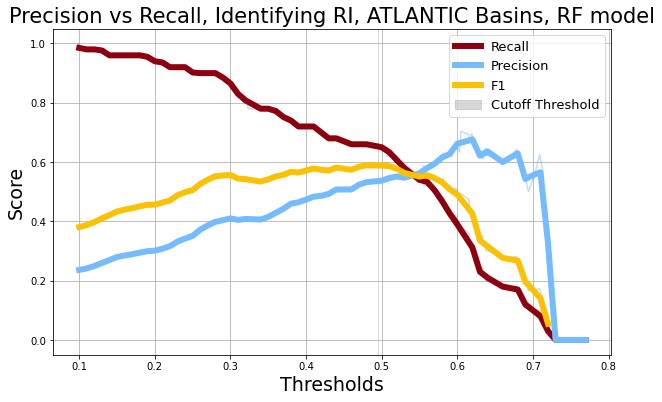

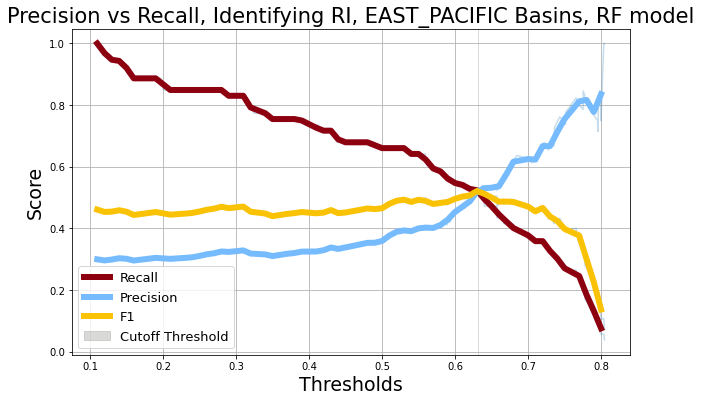

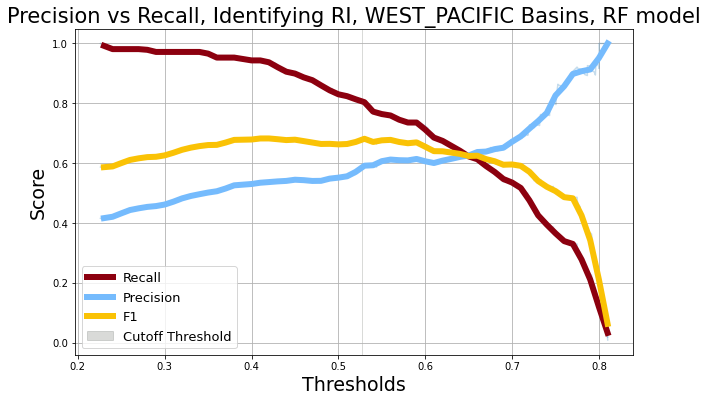

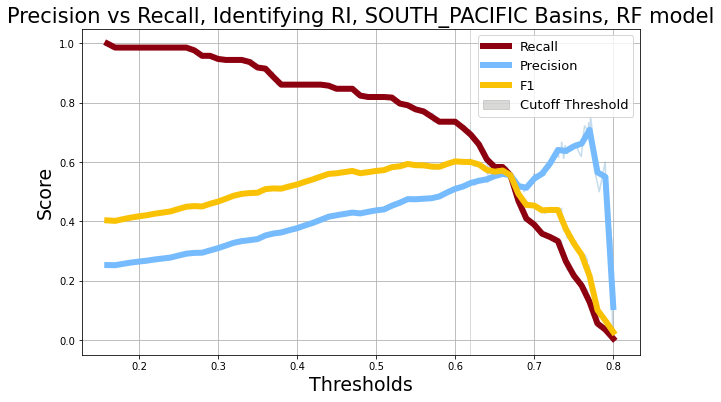

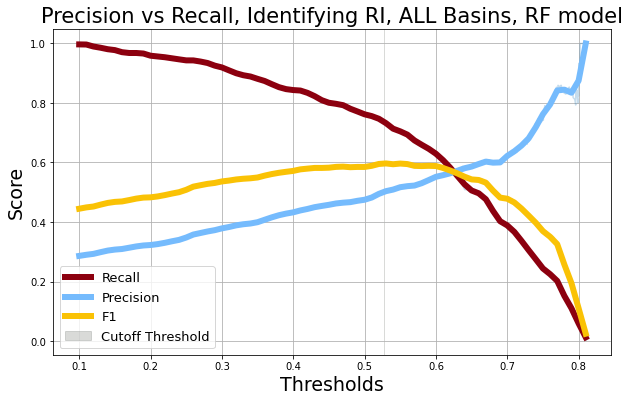

In [16]:
p_vs_r_ALL_plt = p_vs_r_ALL.reset_index()#.iloc[::2]
#basin_sel = 'ALL'

for basin_sel in BASIN_all:
    foo = p_vs_r_ALL_plt.set_index(['BASIN']).loc[basin_sel].drop(columns={'index'})
    foo2 = foo.copy()
    foo2['Thresholds Round'] = foo2['Thresholds'].round(2)
    means_plt = foo2.groupby(['Thresholds Round']).mean().reset_index()
    fig1,ax1 = plt.subplots(1,1,figsize=(10,6))
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='Recall',hue='Fold',ax=ax1,alpha=0.25,legend=None)
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='Precision',hue='Fold',ax=ax1,alpha=0.25,legend=None)
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='F1',hue='Fold',ax=ax1,alpha=0.25,legend=None)
    thresh_min = foo2.reset_index()['Cutoff Threshold'].min()
    thresh_max = foo2.reset_index()['Cutoff Threshold'].max()
    ax1.axvspan(thresh_min,thresh_max,alpha=0.35,color='xkcd:gray',label='Cutoff Threshold')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='Recall',ax=ax1,linewidth=6,color='xkcd:crimson',label='Recall')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='Precision',ax=ax1,linewidth=6,color='xkcd:sky blue',label='Precision')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='F1',ax=ax1,linewidth=6,color='xkcd:goldenrod',label='F1')
    ax1.set_xlabel('Thresholds',fontsize=19)
    ax1.set_ylabel('Score',fontsize=19)
    ax1.legend(fontsize=13)
    ax1.grid()
    ax1.set_title('Precision vs Recall, Identifying RI, {basin_sel} Basins, RF model'.format(basin_sel=basin_sel),fontsize=21)
    fig1.savefig('Model_Results/RF/P_vs_R_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,format=fig_format,
                 dpi=300,bbox_inches='tight')

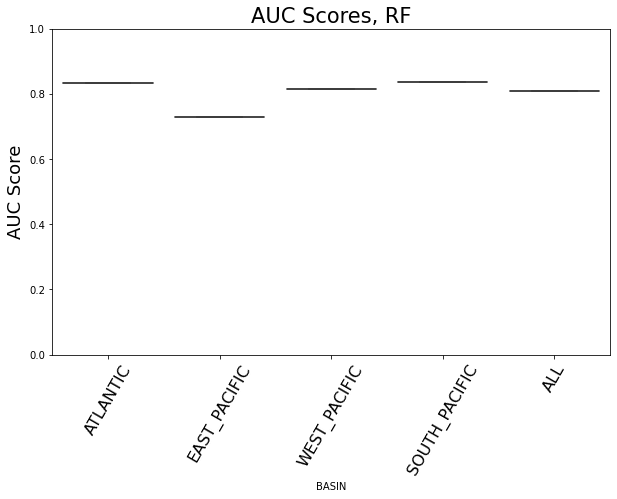

In [17]:
fig3,ax3 = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=roc_vals_ALL,x='BASIN',y='AUC ROC Score',ax=ax3)
ax3.set_ylim([0,1])
ax3.set_xticklabels(roc_vals_ALL['BASIN'].unique(),fontsize=16,rotation=60)
ax3.set_ylabel('AUC Score',fontsize=18)
ax3.set_title('AUC Scores, {solver}'.format(solver='RF'),fontsize=21)
fig3.savefig('Model_Results/RF/AUC_scores_all_basins_RF'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

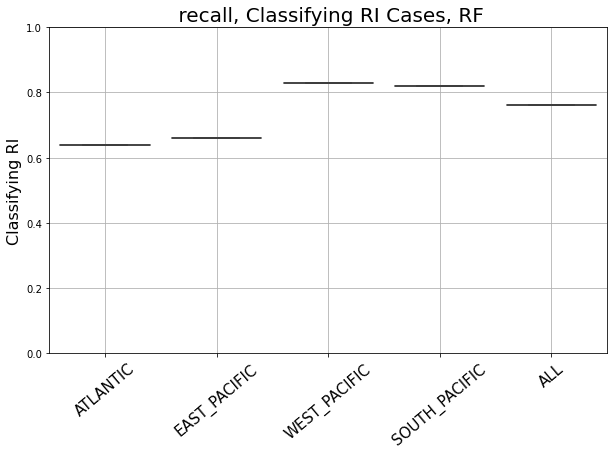

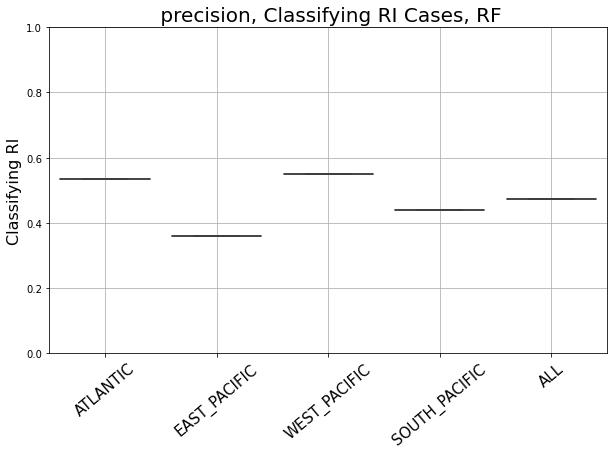

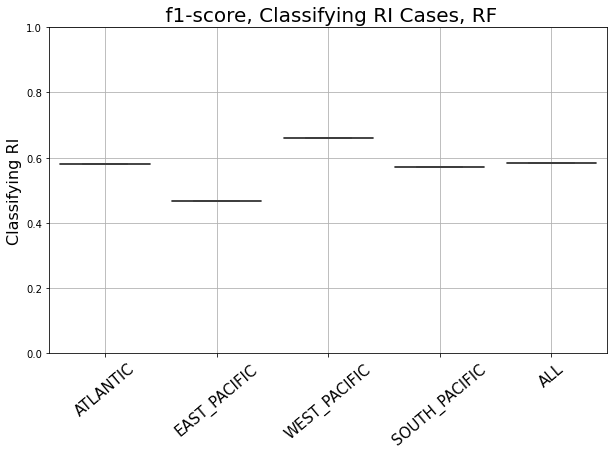

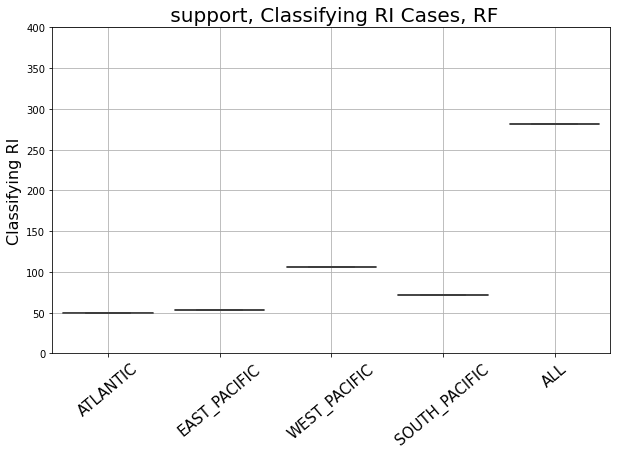

In [18]:
report_plot = report_ALL.reset_index().rename(columns={'index':'Scores','0.0':'not RI','1.0':'RI'})
report_plt_all = report_plot.set_index(['Scores','BASIN','Fold'])
score_sel_ALL = ['recall','precision','f1-score','support']
for score_sel in score_sel_ALL:
    report_plt_mean = report_plt_all.xs((score_sel)).reset_index()
    fig4,ax4 = plt.subplots(1,1,figsize=(10,6))
    sns.boxplot(data=report_plt_mean,x='BASIN',y='RI',ax=ax4)
    if score_sel == 'support':
        ax4.set_ylim([0,400])
    else:
        ax4.set_ylim([0,1])
    ax4.set_ylabel('Classifying RI',fontsize=16)
    ax4.set_xlabel(None)
    ax4.set_xticklabels(report_plt_mean['BASIN'].unique(),fontsize=15,rotation=40)
    ax4.grid()
    ax4.set_title(' {score_sel}, Classifying RI Cases, RF'.format(score_sel=score_sel),fontsize=20)
    fig4.savefig('Model_Results/RF/{score_sel}_all_samples_RI_cases_RF'+save_ext_figs,
                format=fig_format,dpi=300,bbox_inches='tight')
    

In [ ]:
report_plt2 = report_plt_all.loc[['precision','recall','f1-score']].mean(level=(0,1)).reset_index()
fig5,(ax5a,ax5b) = plt.subplots(2,1,figsize=(10,8))
sns.scatterplot(data=report_plt2,x='BASIN',y='not RI',hue='Scores',palette='twilight',s=130,ax=ax5a,alpha=0.7,legend=False)
sns.lineplot(data=report_plt2,x='BASIN',y='not RI',hue='Scores',palette='twilight',linewidth=2,ax=ax5a,alpha=0.7)

sns.scatterplot(data=report_plt2,x='BASIN',y='RI',hue='Scores',palette='magma',s=130,ax=ax5b,alpha=0.7,legend=False)
sns.lineplot(data=report_plt2,x='BASIN',y='RI',hue='Scores',palette='magma',linewidth=2,ax=ax5b,alpha=0.7)

ax5a.set_ylim([0,1])
ax5b.set_ylim([0,1])
ax5a.set_ylabel('not RI',fontsize=18)
ax5b.set_ylabel('RI',fontsize=18)
ax5a.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
ax5a.set_xlabel(None)
ax5b.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
ax5b.set_xlabel(None)
ax5a.grid()
ax5b.grid()
ax5a.legend(fontsize=13)
ax5b.legend(fontsize=13)
fig5.suptitle('Precision, Recall, and F1 Scores, Averaged Over Bootstrapped Samples, RF',fontsize=20)
fig5.tight_layout()
fig5.savefig('Model_Results/RF/Scores_averaged_RI_non_RI'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')


In [ ]:
for basin_sel in BASIN_all:
    fig2,ax2 = plt.subplots(1,1,figsize=(10,7))
    roc_vals_plt = roc_vals_ALL.set_index(['BASIN']).xs(basin_sel).reset_index()
    roc_min = roc_vals_plt['AUC ROC Score'].min()
    roc_max = roc_vals_plt['AUC ROC Score'].max()

    sns.lineplot(data=roc_vals_plt,x='False Positive Rate',y='True Positive Rate',hue='Fold',ax=ax2,legend=False,
                alpha=0.3)
    ax2.plot([0,1],[0,1],color='k',linewidth=2)
    ax2.axhspan(roc_min,roc_max,color='xkcd:gray',alpha=0.25,label='AUC Score')
    ax2.set_xlabel('False Positive Rate',fontsize=18)
    ax2.set_ylabel('True Positive Rate',fontsize=18)
    roc_vals_mean = roc_vals_plt.groupby(roc_vals_plt['False Positive Rate'].round(2))[['True Positive Rate',
                                    'AUC Thresholds']].mean().reset_index()
    roc_vals_mean.plot(x='False Positive Rate',y='True Positive Rate',ax=ax2,color='xkcd:tangerine',linewidth=5,
                      label='ROC curve')
    ax2.legend(fontsize=13)
    ax2.grid()
    ax2.set_title('Identifying RI versus non-RI, {basin_sel} Basins, {solver} model'.format(basin_sel=basin_sel,
                                                                                           solver='RF'),fontsize=21)
    f2_save = 'Model_Results/RF/ROC_curve_{basin_sel}'.format(basin_sel=basin_sel)
    fig2.savefig(f2_save+save_ext_figs,format=fig_format,
                 dpi=300,bbox_inches='tight')

In [ ]:
#sns.heatmap(data=cm_ALL,x='Category',y='Misses')
cm_ALL['BIAS'] = (cm_ALL['Hits']+cm_ALL['False Alarms'])/(cm_ALL['Hits'] + cm_ALL['Misses'])

fig6,((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2,2,figsize=(14,10))
sns.boxplot(data=cm_ALL,x='BASIN',y='Misses',hue='Category Names',palette='twilight',ax=ax6a)
ax6a.set_ylabel('Misses',fontsize=15)
ax6a.legend(fontsize=12)
ax6a.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6a.set_title('Misses',fontsize=19)
ax6a.set_xlabel(None)
#
sns.boxplot(data=cm_ALL,x='BASIN',y='Hits',hue='Category Names',palette='twilight',ax=ax6b)
ax6b.set_ylabel('Hits',fontsize=15)
ax6b.legend(fontsize=12)
ax6b.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6b.set_title('Hits',fontsize=19)
ax6b.set_xlabel(None)
#
sns.boxplot(data=cm_ALL,x='BASIN',y='POD',hue='Category Names',palette='twilight',ax=ax6c)
ax6c.set_ylabel('POD',fontsize=15)
ax6c.legend(fontsize=12)
ax6c.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6c.set_title('Probability of Detection',fontsize=19)
ax6c.set_xlabel(None)
#
#
sns.boxplot(data=cm_ALL,x='BASIN',y='Threat',hue='Category Names',palette='twilight',ax=ax6d)
ax6d.set_ylabel('Threat Score',fontsize=15)
ax6d.legend(fontsize=12)
ax6d.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6d.set_title('Threat Score',fontsize=19)
ax6d.set_xlabel(None)
#

fig6.suptitle('{solver} Model'.format(solver='RF'),fontsize=21)
fig6.tight_layout()
fig6.savefig('Model_Results/RF/CM_results_RI_not_RI_RF'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

In [ ]:
fig7,ax7 = plt.subplots(1,1,figsize=(12,8))
fi_plt = fi_pred_ALL.reset_index().sort_values(['BASIN','mean importance'],ascending=False)
fi_plt['mean mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('mean')
fi_plt['max mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('max')
fi_plt_plt = fi_plt.sort_values(['BASIN','mean mean','max mean'],ascending=[True,False,False])
sns.barplot(data=fi_plt_plt,x='index',y='mean importance',hue='BASIN',
            palette='twilight',ax=ax7)
ax7.set_xticklabels(fi_plt_plt['index'].unique(),fontsize=14,rotation=50)
ax7.set_ylabel('Mean Importance',fontsize=17)
ax7.set_xlabel(None)
ax7.grid()
ax7.tick_params(axis='y',labelsize=14)
ax7.legend(fontsize=13)
ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver}'.format(solver='RF'),fontsize=21)
fig7.tight_layout()
fig7.savefig('Model_Results/RF/Feat_Imp_RI_not_RI'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

##### Each basin separately

In [ ]:
for basin_sel in BASIN_all:
#basin_sel = 'ATLANTIC'
    i_plt = fi_pred_ALL.reset_index().set_index(['BASIN']).xs(basin_sel).sort_values(['mean importance'],ascending=False)
    i_plt['mean mean'] = i_plt.groupby(['index'])['mean importance'].transform('mean')
    i_plt['max mean'] = i_plt.groupby(['index'])['mean importance'].transform('max')
    i_plt_plt = i_plt.sort_values(['mean mean','max mean'],ascending=[False,False])
    fig7,ax7 = plt.subplots(1,1,figsize=(15,10))

    sns.barplot(data=i_plt_plt,x='index',y='mean importance',
                palette='twilight',ax=ax7)
    ax7.set_xticklabels(i_plt_plt['index'].unique(),fontsize=14,rotation=50)
    ax7.set_ylabel('Mean Importance',fontsize=17)
    ax7.tick_params(axis='y',labelsize=14)
    ax7.set_xlabel(None)
    ax7.grid()
    #ax7.legend(fontsize=13)
    ax7.set_title('Feature Importances, not-RI vs RI, {solver}, {basin}'.format(solver='RF',basin=basin_sel),fontsize=21)
    fig7.tight_layout()
    fig7.savefig('Model_Results/RF/Feat_Imp_RI_not_RI_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                format=fig_format,dpi=300,bbox_inches='tight')


###### FI Based on training data only

In [ ]:
fig7,ax7 = plt.subplots(1,1,figsize=(15,10))
fi_plt = fi_pred_train_ALL.reset_index().sort_values(['BASIN','mean importance'],ascending=False)
fi_plt['mean mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('mean')
fi_plt['max mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('max')
fi_plt_plt = fi_plt.sort_values(['BASIN','mean mean','max mean'],ascending=[True,False,False])
sns.barplot(data=fi_plt_plt,x='index',y='mean importance',hue='BASIN',
            palette='twilight',ax=ax7)
ax7.set_xticklabels(fi_plt_plt['index'].unique(),fontsize=14,rotation=50)
ax7.set_ylabel('Mean Importance',fontsize=17)
ax7.set_xlabel(None)
ax7.grid()
ax7.tick_params(axis='y',labelsize=14)
ax7.legend(fontsize=13)
ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver}'.format(solver='RF'),fontsize=21)
fig7.tight_layout()
fig7.savefig('Model_Results/RF/Feat_Imp_TRAIN_RI_not_RI'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

##### And each basin separately again

In [ ]:
for basin_sel in BASIN_all:
#basin_sel = 'ATLANTIC'
    i_plt = fi_pred_train_ALL.reset_index().set_index(['BASIN']).xs(basin_sel).sort_values(['mean importance'],ascending=False)
    i_plt['mean mean'] = i_plt.groupby(['index'])['mean importance'].transform('mean')
    i_plt['max mean'] = i_plt.groupby(['index'])['mean importance'].transform('max')
    i_plt_plt = i_plt.sort_values(['mean mean','max mean'],ascending=[False,False])
    fig7,ax7 = plt.subplots(1,1,figsize=(15,10))

    sns.barplot(data=i_plt_plt,x='index',y='mean importance',
                palette='twilight',ax=ax7)
    ax7.set_xticklabels(i_plt_plt['index'].unique(),fontsize=14,rotation=50)
    ax7.set_ylabel('Mean Importance',fontsize=17)
    ax7.tick_params(axis='y',labelsize=14)
    ax7.set_xlabel(None)
    ax7.grid()
    #ax7.legend(fontsize=13)
    ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver}, {basin}'.format(solver='RF',basin=basin_sel),fontsize=21)
    fig7.tight_layout()
    fig7.savefig('Model_Results/RF/Feat_Imp_RI_not_RI_TRAINING_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                format=fig_format,dpi=300,bbox_inches='tight')


##### Performance diagram

In [ ]:
fig12,ax12 = plt.subplots(1,1,figsize=(12,8))
make_performance_diagram_background(ax12)

#ax12.errorbar(cm_ALL_PD_sel.reset_index()['SR'],cm_ALL_PD_sel.reset_index()['POD'],yerr=cm_ALL_yerr,xerr=cm_ALL_xerr,
 #           linestyle='none',linewidth=2,color='k')
#sns.scatterplot(data=cm_ALL_PD_sel.reset_index(),x='SR',y='POD',hue='BASIN',ax=ax12,palette=sns.set_palette(pal_sel),
  #              s=180,zorder=10)
ax12.set_title('Classifying RI Cases, {solver}'.format(solver='RF'),fontsize=22)
add_model_results(ax12,cm_ALL)
#fig12.savefig('Model_Results/RF/Performance_Diagram'+save_ext_figs,
 #           format='png',dpi=250,bbox_inches='tight')

#### Performance Diagram curves: PoD vs Success Ratio

1. PoD vs Success Ratio curves.  Each fold shown separately, and then averaged across all folds.  Each basin will be separate.
2. AUPD (area under performance diagram) scores. Calculated for each fold and shown as a swarm or box plot, all basins on one plot
3. Max CSI. Calculated for each fold / basin and shown as swarm or box plot, all basins on one plot. 
4. CSI vs Bias.  Calculated for each fold / basin and shown as scatterplot, all basins on one plot. Also show mean across all folds. 


In [ ]:
pd_curves = calculate_PD_curves(p_vs_r_ALL)
fig15,ax15 = plt.subplots(1,1,figsize=(10,6))
max_CSI_ind = p_vs_r_ALL.groupby(['BASIN','Fold'])[['CSI','Bias']].agg({'CSI':'max'}).reset_index()
plot_basic_score_basin(ax15,max_CSI_ind,'CSI',False)
ax15.set_title('Maximum CSI Scores for RI Cases, {solver}'.format(solver='RF'),fontsize=20)
ax15.set_ylabel('Maximum CSI Score',fontsize=16)
ax15.set_ylim([0,0.6])
fig15.savefig('Model_Results/RF/Max_CSI_RI_vs_basin'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

In [ ]:
#sns.swarmplot(data=foo2.reset_index(),x='BASIN',y='CSI')
fig30,ax30 = plt.subplots(1,1,figsize=(10,6))
plot_CSI_vs_bias(p_vs_r_ALL,ax30)
ax30.set_title('Bias at Maximum CSI for RI cases, {solver}'.format(solver='RF'),fontsize=21)
fig30.savefig('Model_Results/RF/CSI_vs_bias_RI'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

##### Area under PD Curve

In [ ]:
aupd_scores = calc_AUPD(p_vs_r_ALL)
aupd_plt = aupd_scores.reset_index().rename(columns={0:'AUPD'})
fig14,ax14 = plt.subplots(1,1,figsize=(10,6))
plot_basic_score_basin(ax14,aupd_plt,'AUPD',True)
ax14.set_ylabel('Area Under PD Curve',fontsize=16)
ax14.set_title('Area Under Performance Diagram, RI Cases, {solver}'.format(solver='RF'),fontsize=21)
ax14.set_ylim([0,0.55])
fig14.savefig('Model_Results/RF/AUPD_calculation_RI_cases'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
for basin_sel in BASIN_all:
    fig23,ax23 = plt.subplots(1,1,figsize=(12,8))
    make_performance_diagram_background(ax23)
    plot_PD_curves(p_vs_r_ALL,ax23,basin_sel)
    ax23.set_title('RI Cases, {basin_sel}, {solver}'.format(basin_sel=basin_sel,solver='RF'),fontsize=22)
    f23_save = 'Model_Results/RF/Performance_Diagram_CURVES_{basin_sel}'.format(basin_sel=basin_sel)
    fig23.savefig(f23_save+save_ext_figs,
                format=fig_format,dpi=300,bbox_inches='tight')